# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Инструкция по выполнению проекта:

Проведите исследовательский анализ набора фотографий.
Подготовьте данные к обучению.
Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt 
# < Перimport seaborn as sns
sns.set()

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


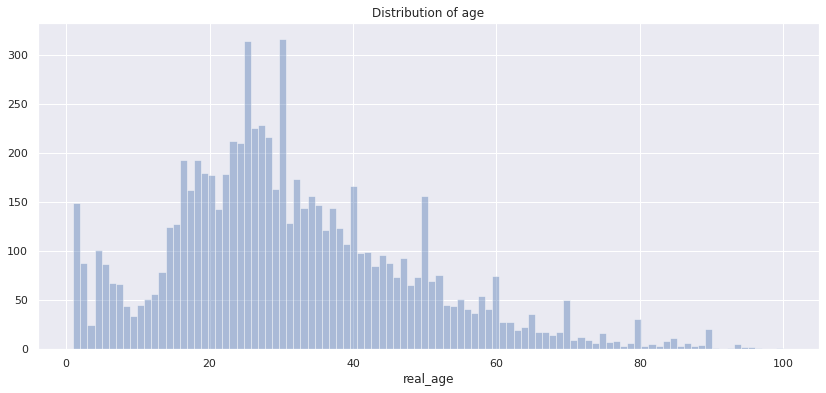

In [6]:
plt.figure(figsize=(14,6))
sns.distplot(labels.real_age, kde=False, bins=100)
plt.title("Distribution of age")
plt.show()

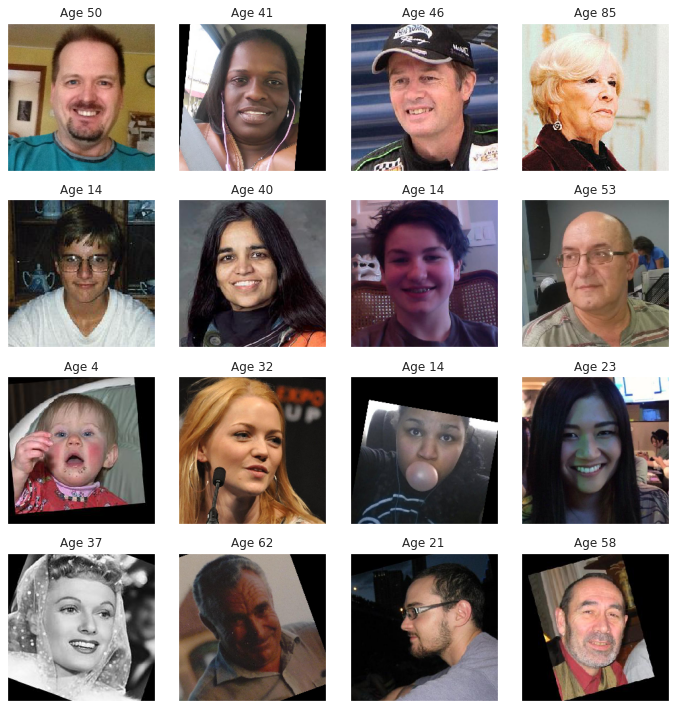

In [7]:
features, target = next(train_gen_flow)


fig= plt.figure(figsize=(10,10))

for i in range(16):
    fig.add_subplot(4,4, i+1)
    plt.imshow(features[i])
  
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Age {target[i]}')
 

Вывод: Получены данные для определения возраста по фотографии. Фото разные - объекты засняты в разных положениях с разным освещением и цветовой гаммой, под разным углом, с разными выржениями лиц. Все это может затруднить обучение модели, тем не менее с учетом количества данных по признакам думаю модель удасться обучить со сравнительно допустимой метрикой ошибки предсказания. Гистограмма распределения целевого признака указыавает, что средний возраст объектов около 30 лет, таким образом модели будет легче предсказать возраст по фото людей средних лет и хуже предсказывать возраст тем кому за 80, поскольку признаков в данной возрастной категории обучающей выборке значительно меньше.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model



```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```



Train for 190 steps, validate for 48 steps
Epoch 1/5

2022-11-10 16:05:55.905787: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2022-11-10 16:05:56.192333: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

190/190 - 52s - loss: 240.1069 - mae: 10.9972 - val_loss: 942.4846 - val_mae: 25.7722
Epoch 2/5

190/190 - 55s - loss: 62.7551 - mae: 6.0139 - val_loss: 831.1918 - val_mae: 23.7602
Epoch 3/5

190/190 - 58s - loss: 31.8142 - mae: 4.3235 - val_loss: 249.8651 - val_mae: 11.7092
Epoch 4/5

190/190 - 55s - loss: 20.3380 - mae: 3.4710 - val_loss: 105.4015 - val_mae: 7.7072
Epoch 5/5

190/190 - 40s - loss: 15.8656 - mae: 3.0887 - val_loss: 68.9140 - val_mae: 6.3922
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
  
48/48 - 8s - loss: 68.9140 - mae: 6.3922
Test MAE: 6.3922

## Анализ обученной модели


- Вывод: полученная модель с использованием архитектуры ResNet дает ошибку в точности предсказания с использованием метрики MAE равную 6.39, что является допустимым значением согласно заданию. Данная модель может определить  возраст людей по фотографии с примерным отклонением 6 лет. Принимая во внимание статистическое распределения возраста объектов по которым обучалась модель, а также неоднородность фотографий в общей выборке, данный результат можно считать вполне примлемым для оценки работы качества модели.


## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы